In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from numpy.lib.stride_tricks import as_strided as strided
import cv2
import numpy as np
import seaborn as sns

In [332]:
coordinates = pd.read_csv('3d_coordinates.csv')

In [3]:
coordinates.columns

Index(['Unnamed: 0', 'frame', 'x', 'y', 'z', 'bodypart'], dtype='object')

In [4]:
coordinates = coordinates.rename(columns={'Unnamed: 0':'frames'}).drop(['frames'], axis=1)

In [5]:
coordinates

,frame,x,y,z,bodypart
0,0.0,NaN,NaN,NaN,elbow
1,0.0,0.081465,-0.337530,-0.014157,wrist
2,0.0,0.002811,-0.309059,-0.007110,thumb1
3,0.0,-0.013208,-0.284525,-0.007068,thumb2
4,0.0,-0.021903,-0.260520,-0.009726,thumb3
...,...,...,...,...,...
10768,512.0,0.015968,-0.245930,-0.013913,ring4
10769,512.0,0.077863,-0.279638,-0.014540,little1
10770,512.0,0.055887,-0.256552,-0.005553,little2
10771,512.0,0.041653,-0.249463,-0.009889,little3


In [6]:
import seaborn as sns

In [133]:
# plt.figure(figsize=(16, 8))
# x = sns.lineplot(data=coordinates, x=coordinates['frame'], y=coordinates['x'], hue=coordinates['bodypart'])
# plt.savefig("x.png")

In [134]:
# plt.figure(figsize=(16, 8))
# y = sns.lineplot(data=coordinates, x=coordinates['frame'], y=coordinates['y'], hue=coordinates['bodypart'])
# plt.savefig("y.png")

In [135]:
# plt.figure(figsize=(16, 8))
# z = sns.lineplot(data=coordinates, x=coordinates['frame'], y=coordinates['z'], hue=coordinates['bodypart'])
# plt.savefig("z.png")

In [136]:
# plt.figure(figsize=(16, 8))
# sns.lineplot(data=little3, x=little3['frame'], y=little3['z'])

In [7]:
""" KALMAN FILTER """

measurement = np.zeros((3,1),dtype=np.float32)
state = np.zeros((9,1),dtype=np.float32)
kalman = cv2.KalmanFilter(9,3,0)

def initKalman(x,y,z):
    measurement[0][0] = x
    measurement[1][0] = y
    measurement[2][0] = y
    kalman.statePre = np.zeros((9,1),dtype=np.float32)
    kalman.statePre[0,0] = x
    kalman.statePre[1,0] = y
    kalman.statePre[2,0] = z
    kalman.statePost = np.zeros((9,1),dtype=np.float32)
    kalman.statePost[0,0] = x
    kalman.statePost[1,0] = y
    kalman.statePost[2,0] = z
    kalman.measurementMatrix=cv2.setIdentity(kalman.measurementMatrix)
    kalman.processNoiseCov=cv2.setIdentity(kalman.processNoiseCov, .01)
    kalman.measurementNoiseCov=cv2.setIdentity(kalman.measurementNoiseCov, .1)
    kalman.errorCovPost=cv2.setIdentity(kalman.errorCovPost, .1)
    dt=1/200
    v = dt
    a = 0.5*(dt**2)
    
    kalman.transitionMatrix = np.array([
                                [1, 0, 0, v, 0, 0, a, 0, 0],
                                [0, 1, 0, 0, v, 0, 0, a, 0],
                                [0, 0, 1, 0, 0, v, 0, 0, a],
                                [0, 0, 0, 1, 0, 0, v, 0, 0],
                                [0, 0, 0, 0, 1, 0, 0, v, 0],
                                [0, 0, 0, 0, 0, 1, 0, 0, v],
                                [0, 0, 0, 0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0, 1]], np.float32)

def kalmanPredict():
    prediction = kalman.predict()
    predictPr = [prediction[0,0],prediction[1,0],prediction[2,0]]
    return predictPr

def kalmanCorrect(x,y,z):
    measurement[0,0] = x
    measurement[1,0] = y
    measurement[2,0] = z
    estimated = kalman.correct(measurement)
    return [estimated[0,0],estimated[1,0],estimated[2,0]]

def mask_knans(a, x):
    a = np.asarray(a)
    k = a.size
    n = np.append(np.isnan(a), [False] * (x - 1))
    m = np.empty(k, np.bool8)
    m.fill(True)

    s = n.strides[0]
    i = np.where(strided(n, (k + 1 - x, x), (s, s)).all(1))[0][:, None]
    i = i + np.arange(x)
    i = pd.unique(i[i < k])

    m[i] = False

    return m

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(~mask_knans(A,3),A,f(inds))
    return B

initialized=False
#sorted_coordinates = coordinates.sort_values(by=['bodypart', 'frame'])
bodyparts=pd.unique(coordinates['bodypart'])
filtered_coordinates=[]
# browse the bodyparts
for bodypart in bodyparts:
    corrected=[]
    #filter coordinates by bodypart
    single_bp = coordinates[coordinates['bodypart'] == bodypart].loc[:,['x','y','z']]
    single_bp = np.array(single_bp)
    for idx in range(len(single_bp)):
        coordinate=single_bp[idx]
        if not np.any(np.isnan(coordinate)):
            if not initialized:
                initKalman(coordinate[0],coordinate[1],coordinate[2])
                initialized=True
                corrected.append(coordinate)
            else:
                p = kalmanPredict()
                s = kalmanCorrect(coordinate[0],coordinate[1],coordinate[2]);   
                corrected.append(s)
        else:
            corrected.append(coordinate)
    corrected=np.vstack(corrected)
#     with np.printoptions(threshold=np.inf):
#         print(corrected)

    for i in range(3):
        corrected[:,i]=fill_nan(corrected[:,i])
        
    filtered_coordinates.append(corrected)
    #with np.printoptions(threshold=np.inf):
        #print(filtered_coordinates)

In [8]:
bodyparts

array(['elbow', 'wrist', 'thumb1', 'thumb2', 'thumb3', 'index1', 'index2',
       'index3', 'index4', 'middle1', 'middle2', 'middle3', 'middle4',
       'ring1', 'ring2', 'ring3', 'ring4', 'little1', 'little2',
       'little3', 'little4'], dtype=object)

In [9]:
kal = coordinates.sort_values(by=['bodypart', 'frame'])
kal

,frame,x,y,z,bodypart
0,0.0,NaN,NaN,NaN,elbow
21,1.0,NaN,NaN,NaN,elbow
42,2.0,NaN,NaN,NaN,elbow
63,3.0,NaN,NaN,NaN,elbow
84,4.0,NaN,NaN,NaN,elbow
...,...,...,...,...,...
10669,508.0,0.081528,-0.344655,-0.032526,wrist
10690,509.0,0.081479,-0.344670,-0.032602,wrist
10711,510.0,0.081453,-0.344681,-0.032621,wrist
10732,511.0,0.081453,-0.344731,-0.032617,wrist


In [20]:
kalman_coordinates = pd.DataFrame.from_records(data=np.vstack(filtered_coordinates), columns=['x', 'y', 'z'])


#print(kalman_coordinates.head())
#print(sorted_coordinates['bodypart'].sort_index())
# kalman_coordinates['bodypart'] = kal['bodypart']
kalman_coordinates['frame'] = coordinates['frame'].reset_index(drop=True)

kalman_coordinates
#kalman_coordinates.to_csv('kalman_coordinates.csv')

,x,y,z,frame
0,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,0.0
3,NaN,NaN,NaN,0.0
4,NaN,NaN,NaN,0.0
...,...,...,...,...
10768,0.039586,-0.243323,-0.001672,512.0
10769,0.039648,-0.243380,-0.001708,512.0
10770,0.039731,-0.243406,-0.001640,512.0
10771,0.039774,-0.243455,-0.001608,512.0


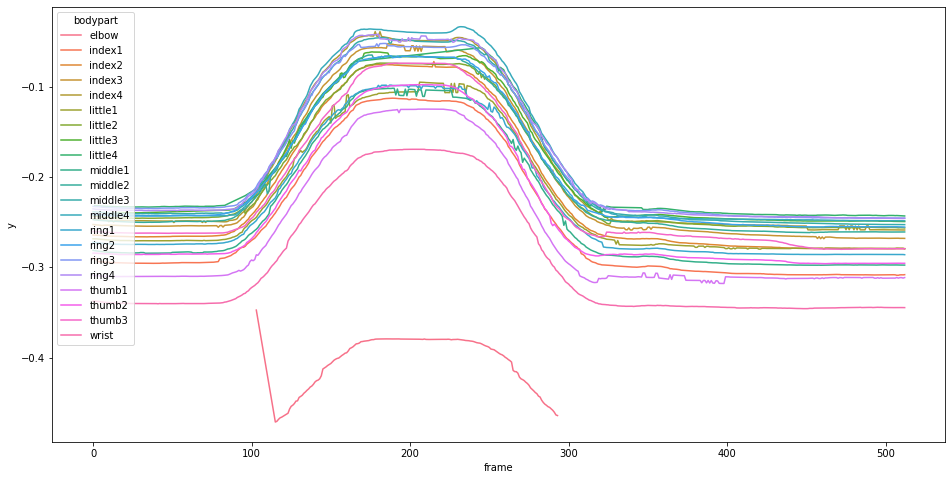

In [15]:
plt.figure(figsize=(16, 8))
z = sns.lineplot(data=kalman_coordinates, x=kalman_coordinates['frame'], y=kalman_coordinates['y'], hue=kalman_coordinates['bodypart'])

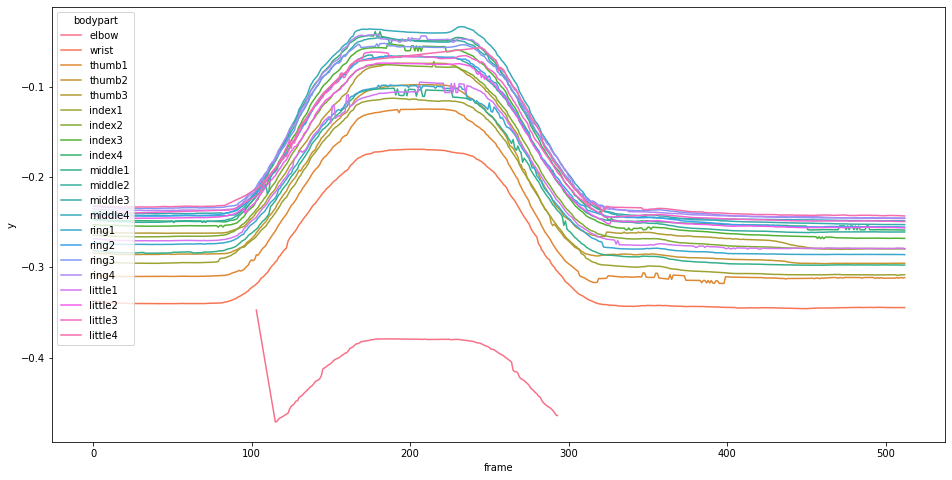

In [16]:
plt.figure(figsize=(16, 8))
z = sns.lineplot(data=coordinates, x=coordinates['frame'], y=coordinates['y'], hue=coordinates['bodypart'])

In [429]:
# plt.figure(figsize=(16, 8))
# plt.subplot(3,1,1)
# plt.plot(range(len(little3)), little3[:,0], label='orig')
# plt.plot(range(len(corrected)), corrected[:,0], label='corrected')
# plt.legend()
# plt.subplot(3,1,2)
# plt.plot(range(len(little3)), little3[:,1], label='orig')
# plt.plot(range(len(corrected)), corrected[:,1], label='corrected')
# plt.subplot(3,1,3)
# plt.plot(range(len(little3)), little3[:,2], label='orig')
# plt.plot(range(len(corrected)), corrected[:,2], label='corrected')

In [656]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import as_strided as strided

def low_pass_filter(coord):

    #Filter requirements
    T = len(coord)/200 # video time
    fps = 200 # frame per rate
    cutoff = 10 # desired cutoff frequency of the filter
    nyq = 0.5 * fps # Nyquist Frequency
    order = 2 # sin wave can be approx represented as quadratic
    normal_cutoff = cutoff / nyq

    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y=np.zeros(coord.shape)*float('NaN')
    y[~np.isnan(coord)] = filtfilt(b, a, coord[~np.isnan(coord)])
    return y

In [657]:
""" Low-pass filter """
bodypart = coordinates[coordinates['bodypart'] == 'elbow']
bodypart_coord = bodypart['x']
y = low_pass_filter(bodypart_coord)
low_pass_bodypart = pd.DataFrame(y, columns = ['x'])
low_pass_bodypart['frame'] = low_pass_bodypart.index
print(low_pass_bodypart)

      x  frame
0   NaN      0
1   NaN      1
2   NaN      2
3   NaN      3
4   NaN      4
..   ..    ...
508 NaN    508
509 NaN    509
510 NaN    510
511 NaN    511
512 NaN    512

[513 rows x 2 columns]


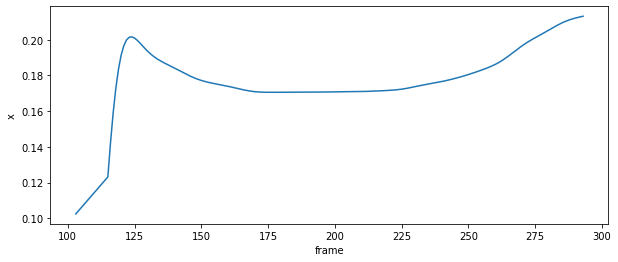

In [658]:
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=low_pass_bodypart, x=low_pass_bodypart['frame'], y=low_pass_bodypart['x'])

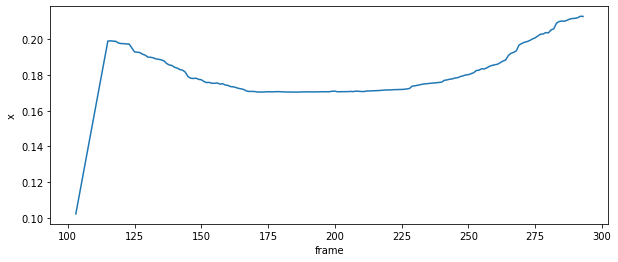

In [659]:
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=bodypart, x=bodypart['frame'], y=bodypart['x'])

In [470]:
def mask_knans(bodypart_x, x):
    a = np.asarray(a)
    k = a.size
    n = np.append(np.isnan(a), [False] * (x - 1))
    m = np.empty(k, np.bool8)
    m.fill(True)

    s = n.strides[0]
    i = np.where(strided(n, (k + 1 - x, x), (s, s)).all(1))[0][:, None]
    i = i + np.arange(x)
    i = pd.unique(i[i < k])

    m[i] = False

    return m

In [636]:
bodypart = coordinates[coordinates['bodypart'] == 'elbow']
bodypart_x = np.array(bodypart['x'])
coord = low_pass_filter(bodypart_x)
print(coord)
low_pass_elbow = pd.DataFrame(coord, columns = ['x'])
low_pass_elbow['frame'] = low_pass_elbow.index
# low_pass_elbow

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan       

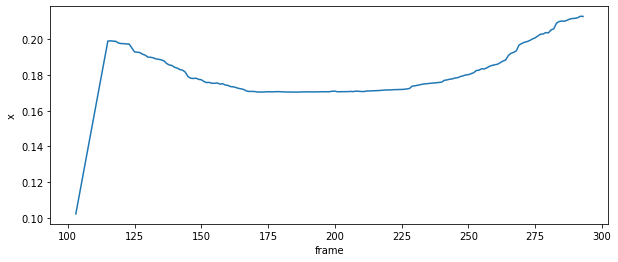

In [637]:
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=bodypart, x=bodypart['frame'], y=bodypart['x'])

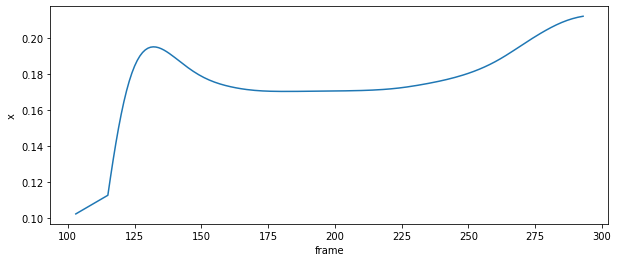

In [638]:
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=low_pass_elbow, x=low_pass_elbow['frame'], y=low_pass_elbow['x'])